# Analyze the data and generate insights that could help Netflix in deciding which type of shows/movies to produce and how they can grow the business in different countries


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv('NetflixCase-Study.csv',encoding='latin-1')

In [3]:
# Challenges in data
# 1 . Nested data in 'title', 'director', 'cast', listed_in
# 2 . Missing Values in 'director','cast' ,'country','date_added','rating'        
# 3 . Duration 
# 4 . date_added coloumn formatting

# Checking for nested columns

In [4]:
def has_nested_values(column):
    for value in column:
        if ',' in str(value):
            return True
    return False

In [5]:
nested_cols = [col for col in df.columns if has_nested_values(df[col])]
nested_cols

['title',
 'director',
 'cast',
 'country',
 'date_added',
 'listed_in',
 'description']

Insight: title','director','cast','country','date_added','listed_in' and 'description' are nested columns

# Checking for duplicated values

In [6]:
df[df.duplicated()]

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description


Insight: No duplicates found

# Custom netflix color palette

In [7]:
netflix_color_palette = sns.color_palette(['black','red'])

# Heat map for null values

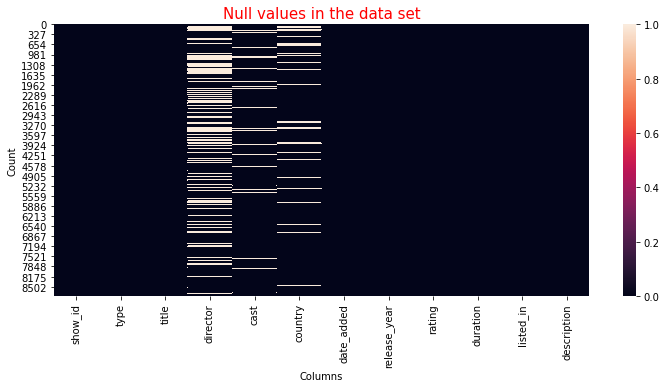

In [8]:
plt.figure(figsize=(12,5))
sns.heatmap(df.isnull())
plt.xlabel('Columns')
plt.ylabel('Count')
plt.title('Null values in the data set', color = 'red', fontsize = 15)
plt.show()

Insight : director, cast and country has null haves and are to be handled.

In [9]:
# Creating a copy of main data frame
netflix = df.copy()

# Handling nested columns 'director','cast','country','listed_in'

In [10]:
netflix['cast']=netflix['cast'].str.split(",")
netflix['listed_in'] = netflix['listed_in'].str.split(",")
netflix['director'] = netflix['director'].str.split(",")
netflix['country'] = netflix['country'].str.split(",")

In [11]:
netflix = netflix.explode('cast').reset_index(drop=True)
netflix = netflix.explode('director').reset_index(drop=True)
netflix = netflix.explode('listed_in').reset_index(drop=True)
netflix = netflix.explode('country').reset_index(drop=True)

# Converting date_added, release_year columns to date object

In [12]:
netflix['date_added']= pd.to_datetime(netflix['date_added'])

In [13]:
netflix['release_year'] = pd.to_datetime(netflix['release_year'].astype(str))

In [14]:
netflix.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202065 entries, 0 to 202064
Data columns (total 12 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   show_id       202065 non-null  object        
 1   type          202065 non-null  object        
 2   title         202065 non-null  object        
 3   director      151422 non-null  object        
 4   cast          199916 non-null  object        
 5   country       190168 non-null  object        
 6   date_added    201907 non-null  datetime64[ns]
 7   release_year  202065 non-null  datetime64[ns]
 8   rating        201998 non-null  object        
 9   duration      202062 non-null  object        
 10  listed_in     202065 non-null  object        
 11  description   202065 non-null  object        
dtypes: datetime64[ns](2), object(10)
memory usage: 18.5+ MB


# Handling null and in-appropriate values

In [15]:
netflix.fillna({'director' : 'Unknown','cast': 'Unknown','country':'Unknown'},inplace= True)
netflix['rating'].fillna(netflix['rating'].mode()[0], inplace= True)
netflix['rating'].replace(['74 min','84 min', '66 min'],netflix['rating'].mode()[0], inplace= True)
netflix['date_added'].fillna(netflix['date_added'].mode()[0], inplace= True)
netflix['duration'].fillna(0, inplace= True)

In [66]:
netflix['rating'].unique()

array(['PG-13', 'TV-MA', 'PG', 'TV-14', 'TV-PG', 'TV-Y', 'TV-Y7', 'R',
       'TV-G', 'G', 'NC-17', 'NR', 'TV-Y7-FV', 'UR'], dtype=object)

In [16]:
netflix.isna().sum(axis=0)

show_id         0
type            0
title           0
director        0
cast            0
country         0
date_added      0
release_year    0
rating          0
duration        0
listed_in       0
description     0
dtype: int64

Insight : All null values are filled with appropriate values.

# Splitting duration and converting to int

In [17]:
netflix['duration'] = netflix['duration'].str.split(" ").str[0]

In [18]:
netflix['duration'].isna().sum()

3

In [19]:
netflix['duration'].fillna(0, inplace= True)

In [20]:
netflix['duration'] = netflix['duration'].astype(int)

# Removing remove leading and trailing spaces from all columns

In [21]:
def dataframe_strip(dataframe):
    for i in dataframe.columns:
        if dataframe[i].dtype == 'object':
            dataframe[i] = dataframe[i].map(str.strip)
        else: 
            pass
# applying funcn to  strip white spaces for each col in dataframe
dataframe_strip(netflix)

Insight : All the null values are treated and unnesting is done. 'netflix' dataframe is ready for analysis

# 1. Find the counts of each categorical variable both using graphical and nongraphical analysis.

In [22]:
netflix_dir_counts = netflix.copy()

In [23]:
dir_cnts = netflix_dir_counts.groupby('director')['title'].nunique().sort_values(ascending = False).drop('Unknown')[:10]

In [24]:
dir_cnts

director
Rajiv Chilaka          22
Jan Suter              21
RaÌ¼l Campos           19
Suhas Kadav            16
Marcus Raboy           16
Jay Karas              15
Cathy Garcia-Molina    13
Youssef Chahine        12
Martin Scorsese        12
Jay Chapman            12
Name: title, dtype: int64

In [25]:
netflix_cast_counts = netflix.copy()

In [26]:
cast_cnts = netflix_cast_counts.groupby('cast')['title'].nunique().sort_values(ascending = False).drop('Unknown')[:10]

In [27]:
cast_cnts

cast
Anupam Kher         43
Shah Rukh Khan      35
Julie Tejwani       33
Takahiro Sakurai    32
Naseeruddin Shah    32
Rupa Bhimani        31
Om Puri             30
Akshay Kumar        30
Yuki Kaji           29
Paresh Rawal        28
Name: title, dtype: int64

In [28]:
netflix_country_counts = netflix.copy()

In [29]:
cntry_cnts = netflix_country_counts.groupby('country')['title'].nunique().sort_values(ascending = False).drop('Unknown')[:10]
cntry_cnts

country
United States     3690
India             1046
United Kingdom     806
Canada             445
France             393
Japan              318
Spain              232
South Korea        231
Germany            226
Mexico             169
Name: title, dtype: int64

In [30]:
netflix_listed_in_counts = netflix.copy()

In [31]:
listed_in_counts = netflix_listed_in_counts.groupby('listed_in')['title'].nunique().sort_values(ascending = False)[:10]
listed_in_counts

listed_in
International Movies        2752
Dramas                      2427
Comedies                    1674
International TV Shows      1351
Documentaries                869
Action & Adventure           859
TV Dramas                    763
Independent Movies           756
Children & Family Movies     641
Romantic Movies              616
Name: title, dtype: int64

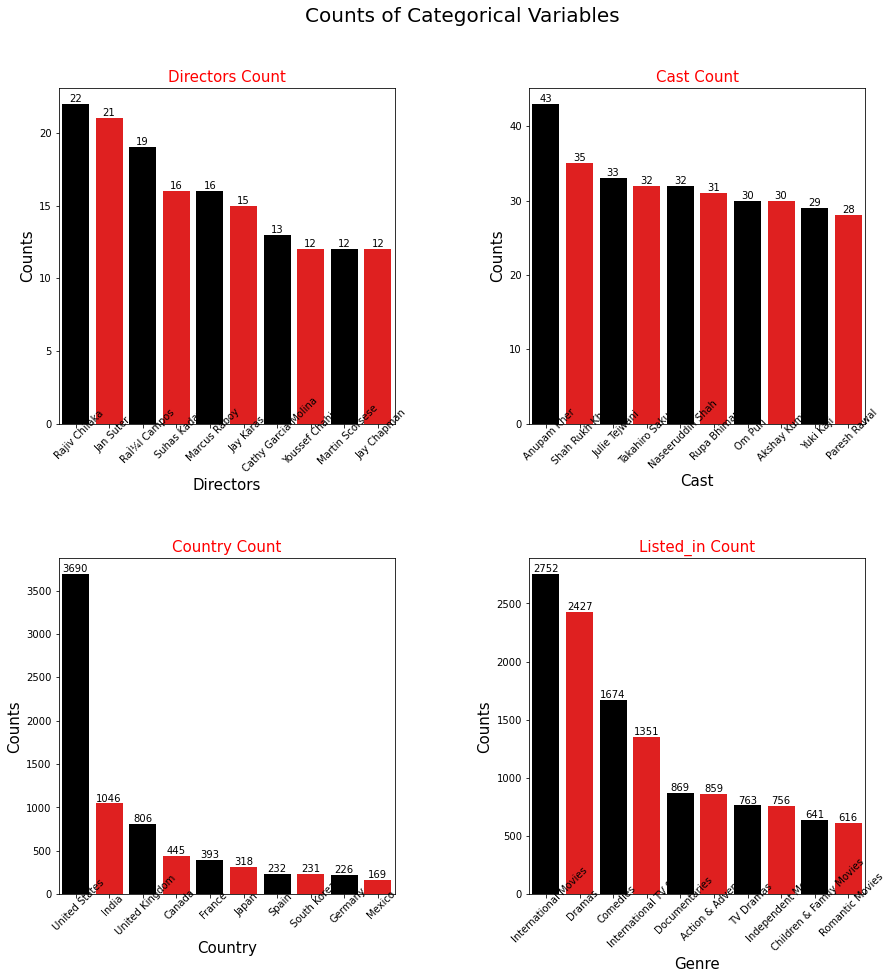

In [32]:
fig = plt.figure(figsize=(14,14))
#fig.tight_layout(pad=10.0)

#subplot 1
plt.subplot(2,2,1)

plot = sns.barplot(x = dir_cnts.index,y = dir_cnts.values, palette = netflix_color_palette)

plt.xticks(rotation = 45,wrap= True, fontsize= 10)

plt.xlabel('Directors', color = 'black', fontsize = 15)
plt.ylabel('Counts', color = 'black', fontsize = 15)

plt.title('Directors Count', color = 'red', fontsize= 15)

for index, value in enumerate(dir_cnts):
    plot.text(index, value , str(value), ha = "center", va = "bottom")
    
#subplot 2
plt.subplot(2,2,2)

plot = sns.barplot(x = cast_cnts.index,y = cast_cnts.values, palette = netflix_color_palette)

plt.xticks(rotation = 45,wrap= True, fontsize=10)

plt.xlabel('Cast', color = 'black', fontsize = 15)
plt.ylabel('Counts', color = 'black', fontsize = 15)

plt.title('Cast Count', color = 'red', fontsize= 15)

for index, value in enumerate(cast_cnts):
    plot.text(index, value , str(value), ha = "center", va = "bottom")

#subplot 3
plt.subplot(2,2,3)

plot = sns.barplot(x = cntry_cnts.index,y = cntry_cnts.values, palette = netflix_color_palette)

plt.xticks(rotation = 45,wrap= True, fontsize=10)

plt.xlabel('Country', color = 'black', fontsize = 15)
plt.ylabel('Counts', color = 'black', fontsize = 15)

plt.title('Country Count', color = 'red', fontsize= 15)

for index, value in enumerate(cntry_cnts):
    plot.text(index, value , str(value), ha = "center", va = "bottom")

#subplot 4
plt.subplot(2,2,4)
plot = sns.barplot(x = listed_in_counts.index,y = listed_in_counts.values, palette = netflix_color_palette)

plt.xticks(rotation = 45,wrap= True, fontsize=10)

plt.xlabel('Genre', color = 'black', fontsize = 15)
plt.ylabel('Counts', color = 'black', fontsize = 15)

plt.title('Listed_in Count', color = 'red', fontsize= 15)

for index, value in enumerate(listed_in_counts):
    plot.text(index, value , str(value), ha = "center", va = "bottom")


fig.suptitle("Counts of Categorical Variables", color = 'black' , fontsize = 20)

plt.savefig('cat_count.jpg')
plt.subplots_adjust(left=0.1,bottom=0.1,right=0.9, top=0.9, wspace=0.4,hspace=0.4)

plt.show()

Insight: The above plot shows that the:
         'Director with max content on netflix' is 'Rajiv Chilaka',
         'Actor with max content on netflix' is 'Anupam Kher',
         'Country with max content on netflix' is 'United States',
         'Genre with max content on netflix' is 'International Movies'
                  

# Creating data frame with date, month, week details

In [33]:
netflix_date = netflix.copy()

In [34]:
netflix_date['year_added']= netflix_date['date_added'].dt.year.astype('Int64')
netflix_date['month_added']=netflix_date['date_added'].dt.month_name().str[0:3]
netflix_date['week_added']= netflix_date['date_added'].dt.isocalendar().week.astype('Int64')

# 2. How has the number of movies released per year changed over the last 20-30 years?

In [35]:
# Exracting movie and tv data
muv_data = netflix_date[netflix_date.type=='Movie'].copy()

In [36]:
tv_data = netflix_date[netflix_date.type=='TV Show'].copy()

In [37]:
muv_year = muv_data[['type','release_year']].reset_index(drop= True)

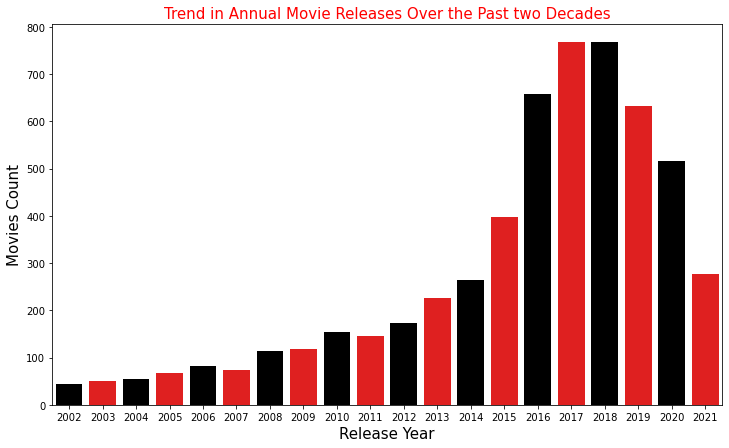

In [38]:
plt.figure(figsize=(12,7))

sns.countplot(x = df.release_year[(df.release_year>2001) & (df.type=='Movie')] ,palette = netflix_color_palette)  
plt.xlabel('Release Year',color = 'black', fontsize = 15)
plt.ylabel('Movies Count',color = 'black', fontsize = 15)
plt.title('Trend in Annual Movie Releases Over the Past two Decades', fontsize=15, color='red')
    
plt.show()

Insight: The data shows that from last 20 years, there has been a notable upward trend in movie releases and a slight decline after 2018.

# 3. Comparison of tv shows vs. movies.

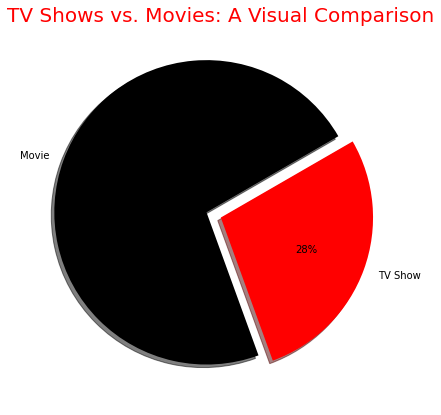

In [39]:
plt.figure(figsize=(12,7))
plt.tight_layout()

plt.pie(netflix_date.groupby('type')['show_id'].count(), labels= netflix_date.type.unique(), 
        colors=netflix_color_palette, autopct='%.0f%%', explode = [0.1, 0], shadow = True, startangle=30)
plt.title('TV Shows vs. Movies: A Visual Comparison',fontsize=20, color = 'red')
plt.show()


Insight: Movies are enjoyed by audiences more than twice as often as TV shows, highlighting their popularity in the realm of entertainment.

# 3a. Find the number of movies produced in each country and pick the top 10 countries.

In [40]:
muv_data.groupby('country')['title'].nunique().drop('Unknown').sort_values(ascending=False)[:10].reset_index()

,country,title
0,United States,2752
1,India,962
2,United Kingdom,534
3,Canada,319
4,France,303
5,Germany,182
6,Spain,171
7,Japan,119
8,China,114
9,Mexico,111


Insights: United States stands in the first place in producing netflix movies with a count of '2364' and next 
          stands India with a movie count of '962'.

# 3b. Find the number of Tv-shows produced in each country and pick the top 10 countries.

In [41]:
tv_data.groupby('country')['title'].nunique().drop('Unknown').sort_values(ascending=False)[:10].reset_index()

,country,title
0,United States,938
1,United Kingdom,272
2,Japan,199
3,South Korea,170
4,Canada,126
5,France,90
6,India,84
7,Taiwan,70
8,Australia,66
9,Spain,61


Insights: United States stands in the first place in producing netflix Tv-shows with a count of '938' and next
          stands India with a movie count of '272'.

# 4. What is the best time to launch a TV show?

In [42]:
# Tv show grouping by month
tv_data_monthGroup = tv_data.groupby('month_added')['show_id'].apply(lambda x : x.count()).reset_index()
month_dict = {'Jan':1,'Feb':2,'Mar':3, 'Apr':4, 'May':5, 'Jun':6, 'Jul':7, 'Aug':8, 'Sep':9, 'Oct':10, 
              'Nov':11, 'Dec':12}
tv_data_monthGroup = tv_data_monthGroup.sort_values('month_added',
                                                    key = lambda x : x.apply (lambda x : month_dict[x]))

In [43]:
# Movie grouping by month
muv_data_monthGroup = muv_data.groupby('month_added')['show_id'].apply(lambda x : x.count()).reset_index()
month_dict = {'Jan':1,'Feb':2,'Mar':3, 'Apr':4, 'May':5, 'Jun':6, 'Jul':7, 'Aug':8, 'Sep':9, 'Oct':10, 
              'Nov':11, 'Dec':12}
muv_data_monthGroup = muv_data_monthGroup.sort_values('month_added',
                                                    key = lambda x : x.apply (lambda x : month_dict[x]))

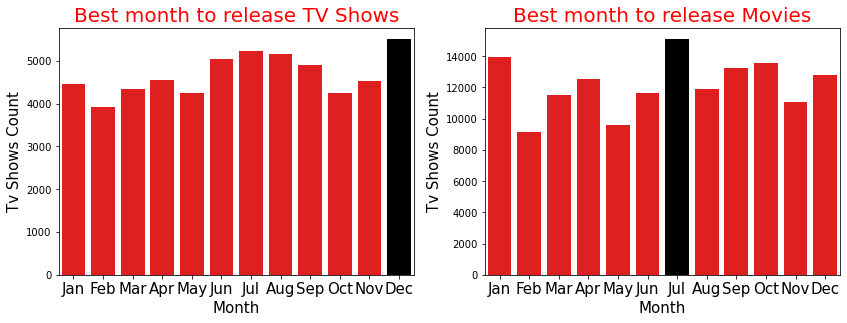

In [44]:
fig = plt.figure(figsize=(14,10))
#plot1
plt.subplot(2,2,1)
cond_color_palette = ['red' if (x < max(tv_data_monthGroup.show_id)) 
                      else 'black' for x in tv_data_monthGroup.show_id]
sns.barplot(x = tv_data_monthGroup.month_added.unique(), y = tv_data_monthGroup.show_id, 
            palette = cond_color_palette)
plt.xlabel('Month', fontsize= 15, color = 'black')
plt.ylabel('Tv Shows Count',fontsize= 15, color = 'black')
plt.xticks(fontsize = 15)
plt.title("Best month to release TV Shows",fontsize=20, color = 'red')
#plot2
plt.subplot(2,2,2)
cond_color_palette = ['red' if (x < max(muv_data_monthGroup.show_id)) 
                      else 'black' for x in muv_data_monthGroup.show_id]
sns.barplot(x = muv_data_monthGroup.month_added.unique(), y = muv_data_monthGroup.show_id, 
            palette = cond_color_palette)
plt.xlabel('Month', fontsize= 15, color = 'black')
plt.ylabel('Tv Shows Count',fontsize= 15, color = 'black')
plt.xticks(fontsize = 15)
plt.title("Best month to release Movies",fontsize=20, color = 'red')
plt.show()

Insight: The data suggests that December is the optimal month for launching TV shows and July is the best motnth to release Movies. These months seem to offer a favorable environment for TV show and Movie premieres.

In [45]:
# Tv show grouping by Week
tv_data_weekGroup = tv_data.groupby('week_added')['show_id'].apply(lambda x : x.count()).reset_index()

In [46]:
# Movies grouping by Week
muv_data_weekGroup = muv_data.groupby('week_added')['show_id'].apply(lambda x : x.count()).reset_index()

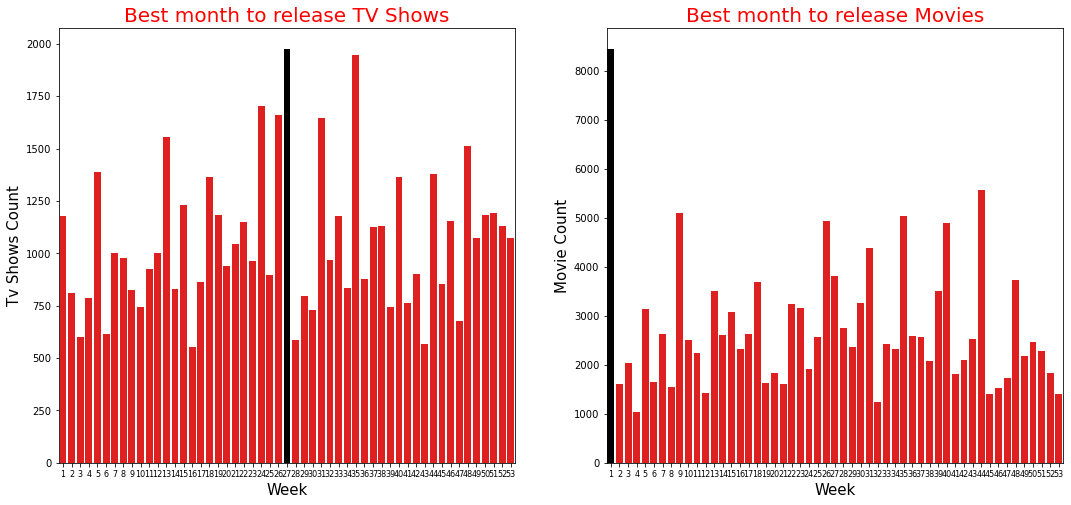

In [47]:
plt.figure(figsize=(18,8))

#plot1
plt.subplot(1,2,1)
cond_color_palette = ['red' if (x < max(tv_data_weekGroup.show_id)) 
                      else 'black' for x in tv_data_weekGroup.show_id]
sns.barplot(x = tv_data_weekGroup.week_added.unique(), y = tv_data_weekGroup.show_id, 
            palette = cond_color_palette)
plt.xlabel('Week', fontsize= 15, color = 'black')
plt.ylabel('Tv Shows Count',fontsize= 15, color = 'black')
plt.xticks(fontsize = 8)
plt.title("Best month to release TV Shows",fontsize=20, color = 'red')

#plot2
plt.subplot(1,2,2)
cond_color_palette = ['red' if (x < max(muv_data_weekGroup.show_id)) 
                      else 'black' for x in muv_data_weekGroup.show_id]
sns.barplot(x = muv_data_weekGroup.week_added.unique(), y = muv_data_weekGroup.show_id, 
            palette = cond_color_palette)
plt.xlabel('Week', fontsize= 15, color = 'black')
plt.ylabel('Movie Count',fontsize= 15, color = 'black')
plt.xticks(fontsize = 8)
plt.title("Best month to release Movies",fontsize=20, color = 'red')
plt.show()

Insights: Data shows that 27th week is the best week to produce TV shows o netflix and 1st week is the best week to release Movies.

# 5. Analysis of actors/directors of different types of shows/movies.

In [48]:
# Getting grouped data of directors, cast for movies and TV shows individually

In [49]:
muv_dir = muv_data.groupby('director')['show_id'].count().drop('Unknown').sort_values( ascending=False)[:10]

In [50]:
muv_cast = muv_data.groupby('cast')['show_id'].count().drop('Unknown').sort_values(ascending=False)[:10]

In [51]:
tv_dir = tv_data.groupby('director')['show_id'].count().drop('Unknown').sort_values(ascending=False)[:10]

In [52]:
tv_cast = tv_data.groupby('cast')['show_id'].count().drop('Unknown').sort_values(ascending=False)[:10]

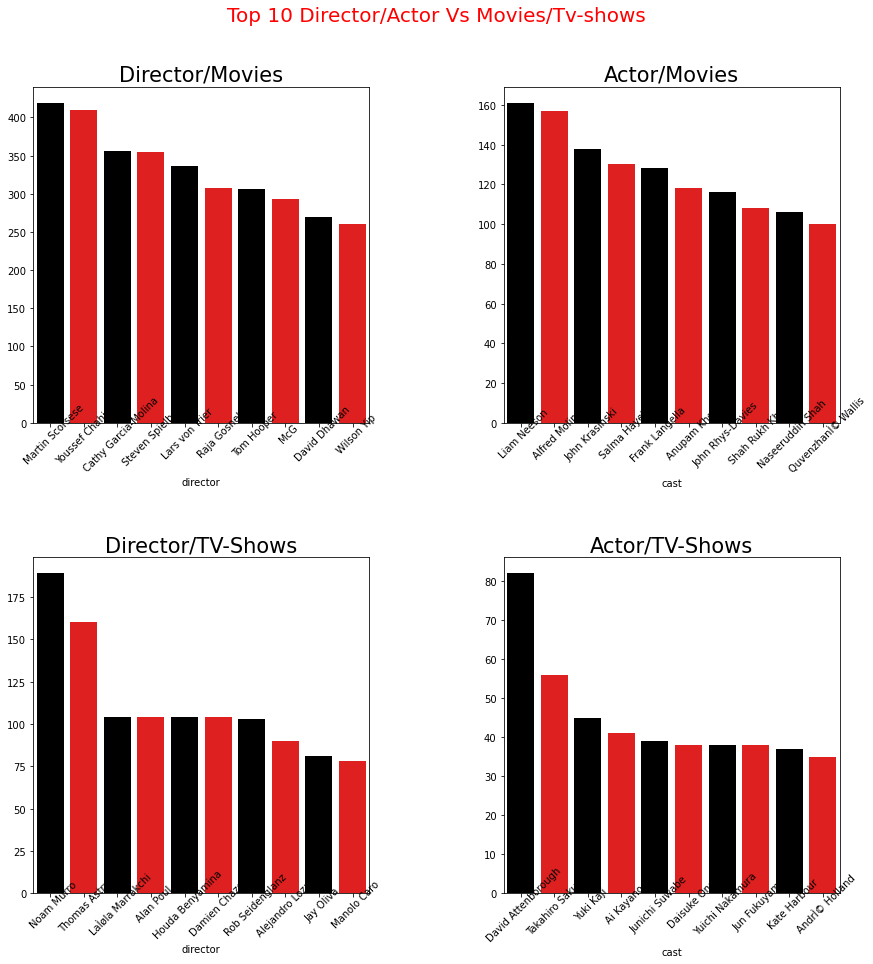

In [53]:
fig = plt.figure(figsize=(14,14))
#fig.tight_layout(pad=10.0)

#subplot 1
plt.subplot(2,2,1)
sns.barplot(x= muv_dir.index, y = muv_dir.values, palette= netflix_color_palette)
plt.xticks(rotation=45, wrap=True)
plt.title('Director/Movies', fontsize=21)

#subplot 1
plt.subplot(2,2,2)
sns.barplot(x= muv_cast.index, y = muv_cast.values, palette= netflix_color_palette)
plt.xticks(rotation=45, wrap=True)
plt.title('Actor/Movies', fontsize=21);

#subplot 1
plt.subplot(2,2,3)
sns.barplot(x= tv_dir.index, y = tv_dir.values, palette= netflix_color_palette)
plt.xticks(rotation=45, wrap=True)
plt.title('Director/TV-Shows', fontsize=21);

#subplot 1
plt.subplot(2,2,4)
sns.barplot(x= tv_cast.index, y = tv_cast.values, palette= netflix_color_palette)
plt.xticks(rotation=45, wrap=True)
plt.title('Actor/TV-Shows', fontsize=21);

plt.savefig('Dir_Actor-Movie_Tv.jpg')
plt.subplots_adjust(left=0.1,bottom=0.1,right=0.9, top=0.9, wspace=0.4,hspace=0.4)

plt.suptitle("Top 10 Director/Actor Vs Movies/Tv-shows", fontsize=20, color='red')
plt.show()

Insights: From the above plot it is known that: 
          Best director for movies is 'Martin Scorsense'
          Best actor for movies is 'Liam Neeson'
          Best director for tv shows is 'Noam Murro'
          Best actor for tv shows is 'David Attenborough'

# 6. Which genre movies are more popular or produced more

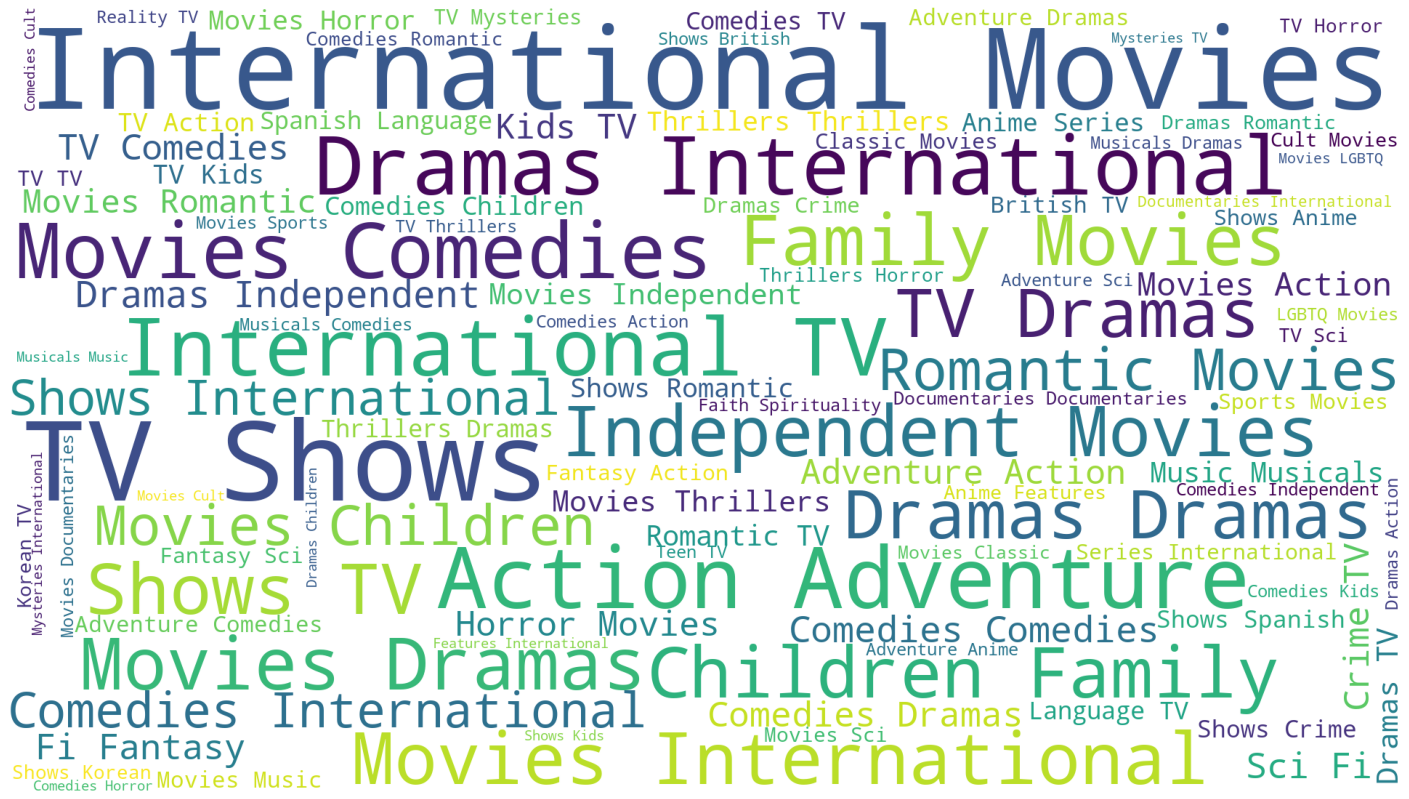

In [54]:
plt.figure(figsize=(25,15))

text = str(list(netflix_date['listed_in'])).replace(',', '').replace('[', '').replace("'", '').replace(']', '').replace('.', '')

# Generate a word cloud image
wordcloud = WordCloud(stopwords=STOPWORDS, max_words=100, background_color='white',
                          width=1920,
                          height=1080).generate(text)
                                                    
plt.imshow(wordcloud)
plt.axis('off')
plt.savefig('country.png')
plt.show()

Insights: From the above word cloud , International movies are produced more on netflix and next to it will be TV shows.

# 5. Does Netflix has more focus on TV Shows than movies in recent years

In [55]:
grpd_tv_data = tv_data.groupby('year_added')['show_id'].count().reset_index()

In [56]:
grpd_muv_data = muv_data.groupby('year_added')['show_id'].count().reset_index()

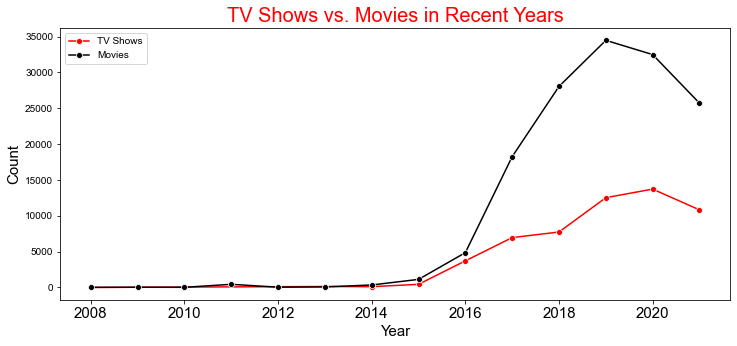

In [57]:
plt.figure(figsize=(12,5))
sns.lineplot(x = grpd_tv_data.year_added , y = grpd_tv_data.show_id, 
             color='red', marker = 'o', label= 'TV Shows')
sns.lineplot(x = grpd_muv_data.year_added , y = grpd_muv_data.show_id, 
             color = 'black', marker = 'o', label= 'Movies')
sns.set_theme(style='white')
plt.xlabel('Year', fontsize= 15, color = 'black')
plt.ylabel('Count',fontsize= 15, color = 'black')
plt.xticks(fontsize = 15)
plt.title("TV Shows vs. Movies in Recent Years",fontsize=20, color = 'red')
plt.show()

Insight: The above line plot shows a parallel Growth of TV Shows and Movies Until 2016, followed by exponential movie expansion.

In [58]:
grpd_data = netflix_date.groupby(['year_added','type'])['show_id'].count().reset_index()

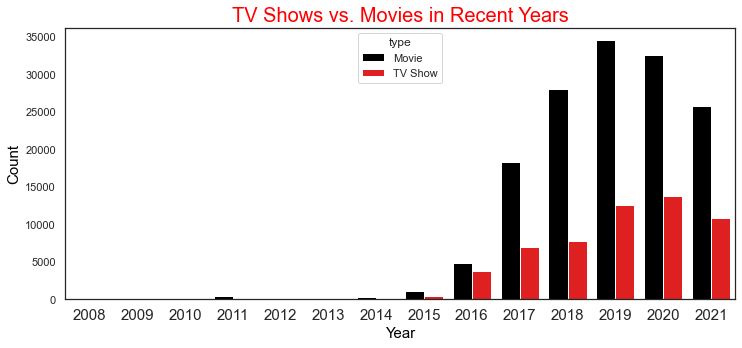

In [59]:
plt.figure(figsize=(12,5))
cols = sns.color_palette(['black','red'])
sns.barplot(x = grpd_data.year_added , y = grpd_data.show_id, hue= grpd_data.type, palette = cols )
sns.set_theme(style='white')
plt.xlabel('Year', fontsize= 15, color = 'black')
plt.ylabel('Count',fontsize= 15, color = 'black')
plt.xticks(fontsize = 15)
plt.title("TV Shows vs. Movies in Recent Years",fontsize=20, color = 'red')
plt.show()

Insight: The Movie Boom (2016-2019): Between 2016 and 2019, the movie industry witnessed an exponential upswing.
         Consistent TV Shows: TV shows, on the other hand, held their ground with a steady pace. 
         The Decline of Movies (Post-2019): The drop in movie production after 2019 raises intriguing questions 
         like Market Saturation, Return on Investment etc

# 6. Understanding what content is available in different countries

In [60]:
# Getting top 5 countries with content on netflix

In [61]:
top_countries = list(netflix_date.country.value_counts().drop('Unknown')[:5].index)

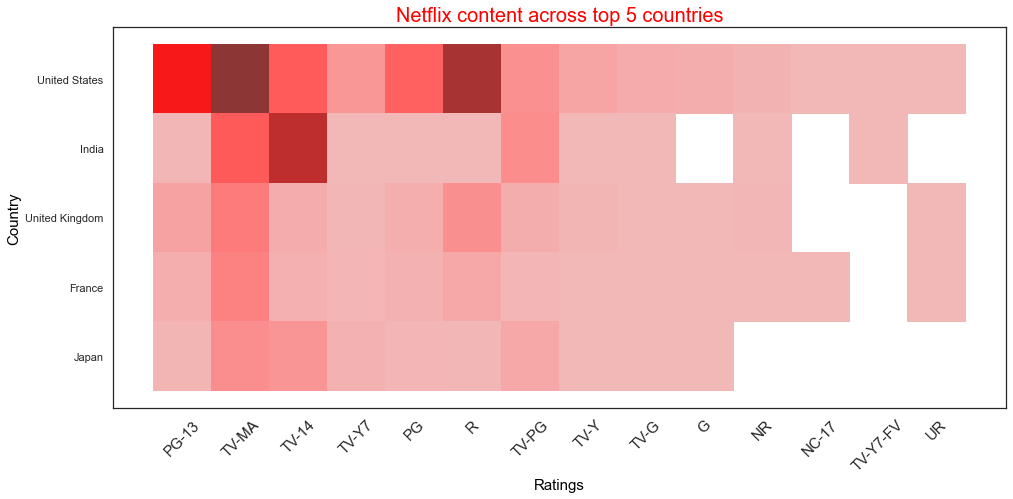

In [62]:
plt.figure(figsize=(16,7))
sns.histplot(data= netflix_date[netflix_date['country'].isin(top_countries)], x= "rating", y= 'country', color = 'red')
sns.set_theme(style='dark')
plt.xlabel('Ratings', fontsize= 15, color = 'black')
plt.ylabel('Country',fontsize= 15, color = 'black')
plt.xticks(rotation = 45, fontsize = 15)

plt.title("Netflix content across top 5 countries",fontsize=20, color = 'red')
plt.show()

Insights: The above heatmap shows the ratings across top 5 countries. Netflix content with rating 'TV-MA' is mostly avaible in United States where as 'TV-14' is the top availabe rated content in India. 
India has no G, NC-17, UR content availabe where as Japan has no NR, NC-17 , TV-Y7-FV and UR rated content availabe.

# 7. Find After how many days the content will be added to Netflix after the release of the movie 

In [63]:
netflix_date['days_to_add']=netflix_date['date_added']-netflix_date['release_year']

In [64]:
netflix_date['days_to_add'].mode()[0]

Timedelta('547 days 00:00:00')

Insight : An average of 547 days are taken to add a movie or a tv show to netflix after its relase.
         (Considering each show or movie is released on jan 1 of the respective release year as the exact date 
          of release is not availabe )

In [68]:
netflix_date['country'].nunique()

124